# Model Two: Two-Sided Search


In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize as opt
from scipy import integrate as intg
from scipy.optimize import least_squares
from scipy.stats import beta
from scipy.stats import cumfreq, beta
%matplotlib inline
plt.style.use('notebook.mplstyle')

## Exogenous Parameters


In [2]:
# Setting exogenous parameters
def reset_exog_params():
    global Bm, Bw, bm_vals, bw_vals, δ, u, Fm, Fw, λm, λw  
    Bm = 10
    Bw = 10
    bm_vals = range(1,Bm+1) 
    bw_vals = range(1,Bw+1)
    
    δ = 0.95
    u = lambda θ : θ 
    Fm = beta(1,1)
    Fw = beta(1,1)
    λm = 90
    λw = 30

## Steady State with Cutoff Strategies

In [3]:
def steady_state(μ, ω, verbose=False): 
    # Computing z's
    zm = []
    for b in bm_vals:
        if b==Bm:
            zm.append(1-δ*Fw.cdf(μ[Bm-1]))
        else:    
            z=1
            for i in range(1, Bm-b+1): 
                z *= ((δ*(1-Fw.cdf(μ[Bm-i])))/(1-δ*Fw.cdf(μ[Bm-i-1])))   
            zm.append(z)  
        
    zw = []
    for b in bw_vals:
        if b==Bw:
            zw.append(1-δ*Fw.cdf(ω[Bw-1]))
        else:    
            z=1
            for i in range(1, Bw-b+1): 
                z *= ((δ * (1-Fm.cdf(ω[Bw-i])))/(1-δ*Fm.cdf(ω[Bw-i-1])))
            zw.append(z)    
    
    # Computing steady-state masses
    Nm = λm * ((zm[Bm-1] - δ * zm[0] * (1 - Fw.cdf(μ[0]))) / ((1-δ) * zm[Bm-1]))
    Nw = λw * ((zw[Bw-1] - δ * zw[0] * (1 - Fm.cdf(ω[0]))) / ((1-δ) * zw[Bw-1]))   
    
    # Computing steady state distribution over budgets 
    Pbm = [(λm / (Nm * zm[Bm-1])) * zm[b] for b in range(Bm-1)]
    Pbw = [(λw / (Nw * zw[Bw-1])) * zw[b] for b in range(Bw-1)]
    Pbm.append((λm / (Nm * zm[Bm-1])))
    Pbw.append((λw / (Nw * zw[Bw-1]))) 
    
    # Computing tightness and alpha
    if Nw>Nm:
        τm = 1
    else:
        τm = Nw/Nm 
        
    τw = τm *(Nm/Nw) 
    αm = (τm*δ)/(1-δ*(1-τm))
    αw = (τw*δ)/(1-δ*(1-τw))
    return Nm, Nw, Pbm, Pbw, τm, τw, αm, αw

## Ex-Interim Utilities

In [4]:
def ex_ante_utilities(μ, ω, Pbm, Pbw):
    # Computing ex-ante expected utilities
    Um = lambda θ : u(θ)*(sum([(1 - Fm.cdf(ω[b]))*Pbw[b] for b in range(Bw)]))
    Uw = lambda θ : u(θ)*(sum([(1 - Fw.cdf(μ[b]))*Pbm[b] for b in range(Bm)]))
    return Um, Uw

## Two-Sided Search Equilibrium Conditions 


In [5]:
# Optimality conditions
def SME(x, ex_ante=False): 
    # Compute steady state 
    Nm, Nw, Pbm, Pbw, τm, τw, αm, αw = steady_state(x[:Bm], x[Bm:])
    
    Um = u
    Uw = u
    # Computing ex-ante expected utilities
    if ex_ante: 
        Um, Uw = ex_ante_utilities(x[:Bm], x[Bm:], Pbm, Pbw) 
    
    # Initialysing system of equilibrium equations
    E = np.empty(2*Bm + 2*Bw + 2)
    
    # Initial conditions 
    E[0] = (Um(x[0]) 
            - αm * Um(x[0]) * Fw.cdf(x[0]) 
            - αm * intg.quad(lambda t: Um(t) * Fw.pdf(t), x[0], 1)[0]) 
    
    E[Bm] = (Uw(x[Bm]) 
            - αw * Uw(x[Bm]) * Fm.cdf(x[Bm]) 
            - αw * intg.quad(lambda t: Uw(t) * Fm.pdf(t), x[Bm], 1)[0]) 
    
    # Intertemporal optimality conditions for men
    for b in range(1,Bm):
        E[b] = (Um(x[b]) 
                - αm * Um(x[b]) * Fw.cdf(x[b]) 
                - αm * Um(x[b-1])*(1-Fw.cdf(x[b-1])) 
                - αm * intg.quad(lambda t : Um(t) * Fw.pdf(t), x[b], x[b-1])[0])
    
    # Intertemporal optimality conditions for women
    for b in range(1,Bw):
        E[Bm+b] = (Uw(x[Bm+b]) 
                - αw * Uw(x[Bm+b]) * Fm.cdf(x[Bm+b]) 
                - αw * Uw(x[Bm+b-1])*(1-Fm.cdf(x[Bm+b-1])) 
                - αw * intg.quad(lambda t : Uw(t) * Fm.pdf(t), x[Bm+b], x[Bm+b-1])[0])
        
    # PMF unity sum conditions
    E[Bm+Bw] = sum(Pbm)-1
    E[Bm+Bw+1] = sum(Pbw)-1
    
    # PMF non-negativity conditions
    for b in range(Bm):
        E[Bm+Bw+2+b] = Pbm[b]-abs(Pbm[b])
        
    for b in range(Bw): 
        E[Bm+Bw+2+Bm+b] = Pbw[b]-abs(Pbw[b])    
        
    return E 

## Solving For Stationary Ex-Ante Markov Equilibria 

In [6]:
reset_exog_params()
m_test = np.random.rand(Bm)#*0.5
w_test = np.random.rand(Bw)#*0.5 
#m_test = m_test[::-1]
#w_test = w_test[::-1]

print('Starting men: ', m_test)
print('Starting women: ', w_test)

x_start = np.concatenate((m_test, w_test), axis=None)
solution = least_squares(SME, x_start, bounds = (0,1), 
                         verbose=1, args={False}) 

print('')
print(solution.x) 
print('Loss:', round(solution.cost,6))

Starting men:  [0.17448166 0.57908025 0.13114488 0.70060848 0.96300357 0.7992329
 0.13644614 0.61210358 0.81818625 0.74123808]
Starting women:  [0.04133413 0.55696967 0.57361976 0.82748038 0.53401928 0.27824289
 0.89691423 0.20643927 0.56552507 0.25286136]
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 6.2760e-01, final cost 1.6198e-18, first-order optimality 1.72e-10.

[0.6015398  0.46854955 0.38110667 0.31687179 0.26708834 0.22725147
 0.19468861 0.16766582 0.14498657 0.12578708 0.72394747 0.62340176
 0.55277212 0.49761265 0.45227644 0.41385592 0.38062107 0.35144437
 0.32554311 0.30234807]
Loss: 0.0


In [7]:
# Computing steady state
μ_star = solution.x[:Bm]
ω_star = solution.x[Bm:]
Nm, Nw, Pbm, Pbw, τm, τw, αm, αw = steady_state(μ_star, ω_star, True)
print('Masses: ', round(Nm), round(Nw))
print('PMF check:', round(sum(Pbm),3), round(sum(Pbw),3))
print('Tightness: ', round(τm,2), round(τw,2))
print('Alphas: ', round(αm,2), round(αw,2)) 
ρm = sum([(1 - Fm.cdf(ω_star[b]))*Pbw[b] for b in range(Bw)])
ρw = sum([(1 - Fw.cdf(μ_star[b]))*Pbm[b] for b in range(Bm)])
print('Pr(right-swipe): ', round(ρm, 2), round(ρw, 2))

Masses:  952 380
PMF check: 1.0 1.0
Tightness:  0.4 1.0
Alphas:  0.88 0.95
Pr(right-swipe):  0.54 0.71


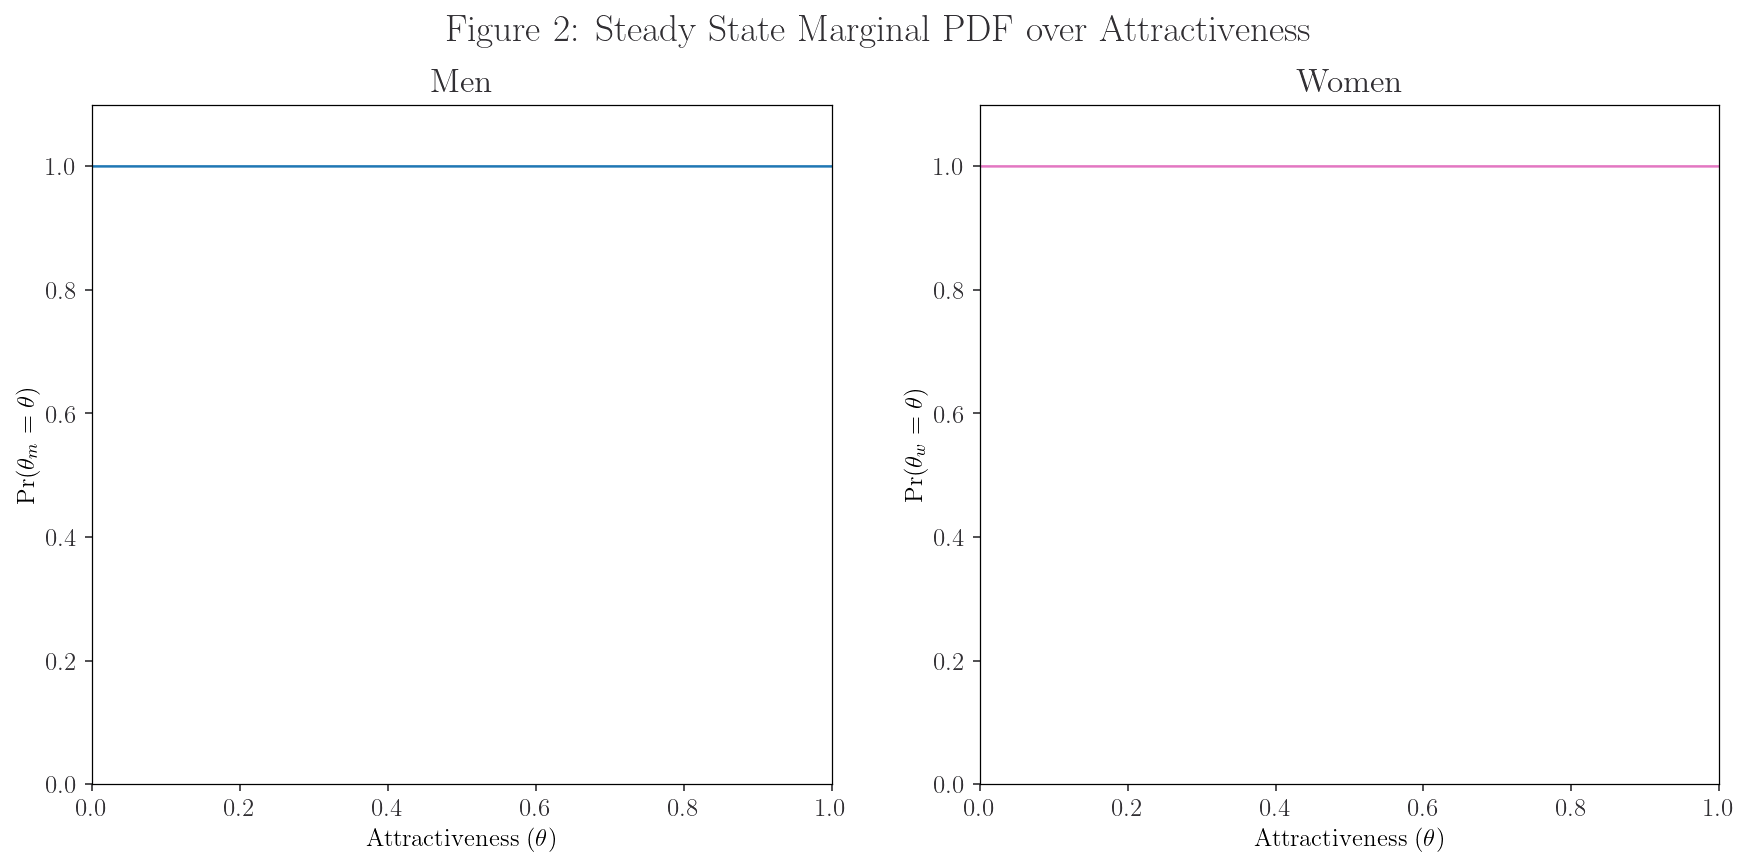

In [8]:
# Plotting Marginal PDFs
fig, axs = plt.subplots(1,2,figsize=(14, 6))
x = np.linspace(0, 1, 5000)

axs[0].set_xlim(0,1)
axs[0].set_ylim(0,1.1*max(Fm.pdf(x)))
axs[0].plot(x, Fm.pdf(x), color='tab:blue') 

axs[1].set_xlim(0,1)
axs[1].set_ylim(0,1.1*max(Fw.pdf(x)))
axs[1].plot(x, Fw.pdf(x), color='tab:pink') 

axs[0].set_title('Men',loc='center')
axs[0].set(xlabel=r'Attractiveness ($\theta$)', ylabel=r'Pr($\theta_m=\theta$)')

axs[1].set_title('Women',loc='center')
axs[1].set(xlabel=r'Attractiveness ($\theta$)', ylabel=r'Pr($\theta_w=\theta$)')
fig.suptitle('Figure 2: Steady State Marginal PDF over Attractiveness')
plt.show()

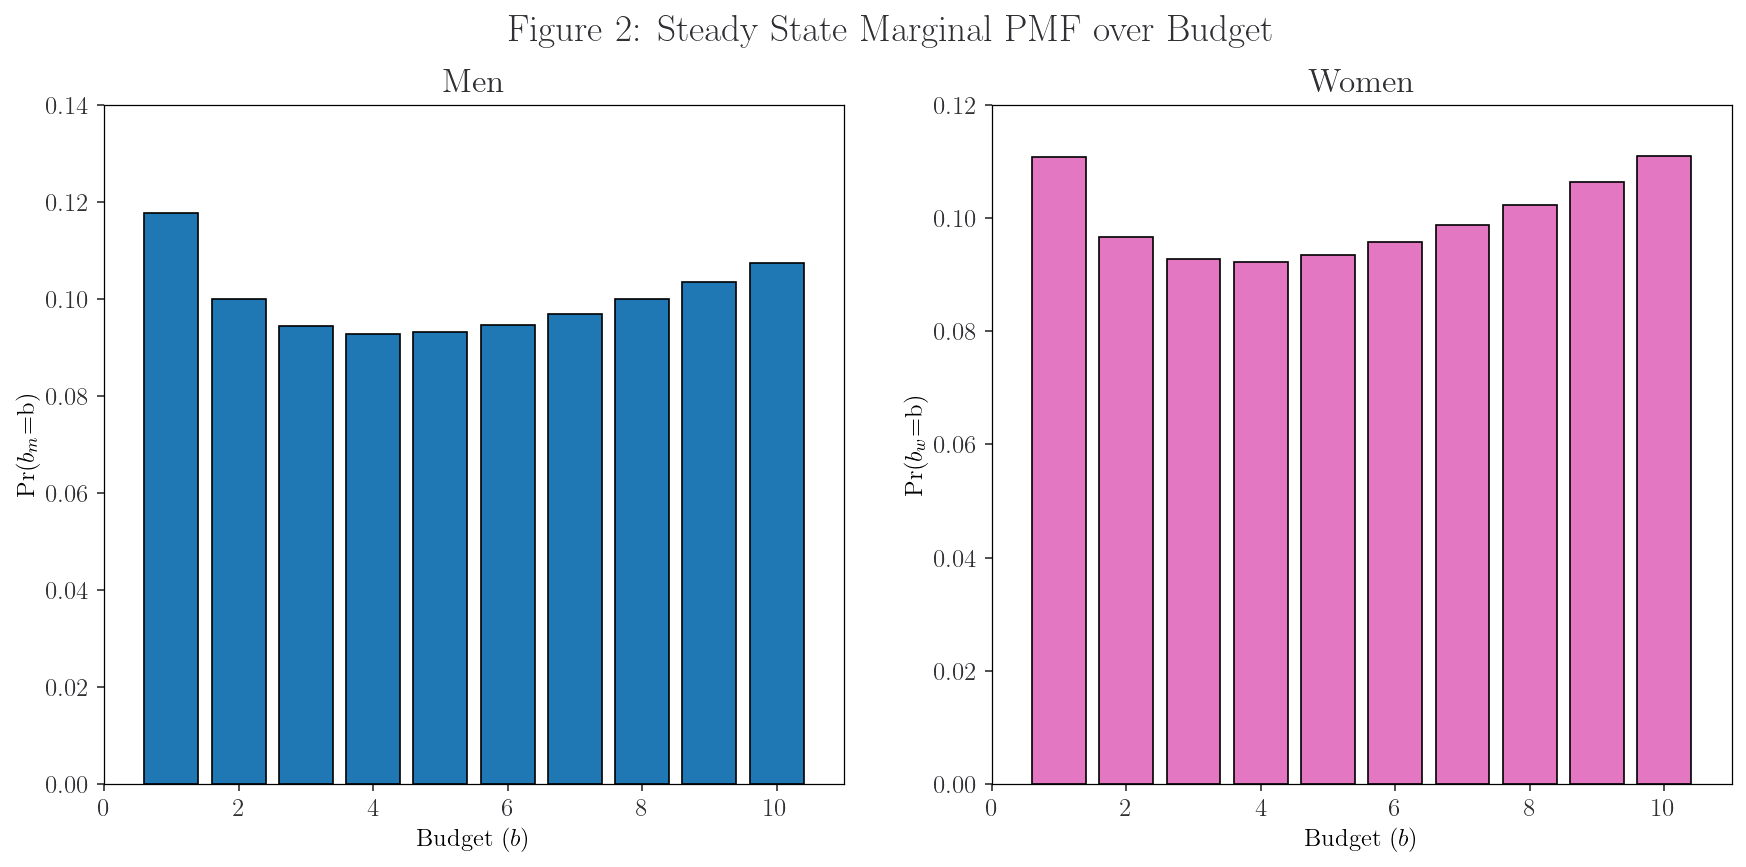

In [9]:
# Plotting Marginal PMFs
fig, axs = plt.subplots(1,2,figsize=(14, 6))
axs[0].set_xlim(0,Bm+1)
axs[0].bar(bm_vals, Pbm, color='tab:blue') 
axs[1].set_xlim(0,Bw+1)
axs[1].bar(bw_vals, Pbw, color='tab:pink') 
axs[0].set_title('Men',loc='center')
axs[0].set(xlabel=r'Budget ($b$)', ylabel=r'Pr($b_m$=b)')
axs[1].set_title('Women',loc='center')
axs[1].set(xlabel=r'Budget ($b$)', ylabel=r'Pr($b_w$=b)')
fig.suptitle('Figure 2: Steady State Marginal PMF over Budget')
plt.show()

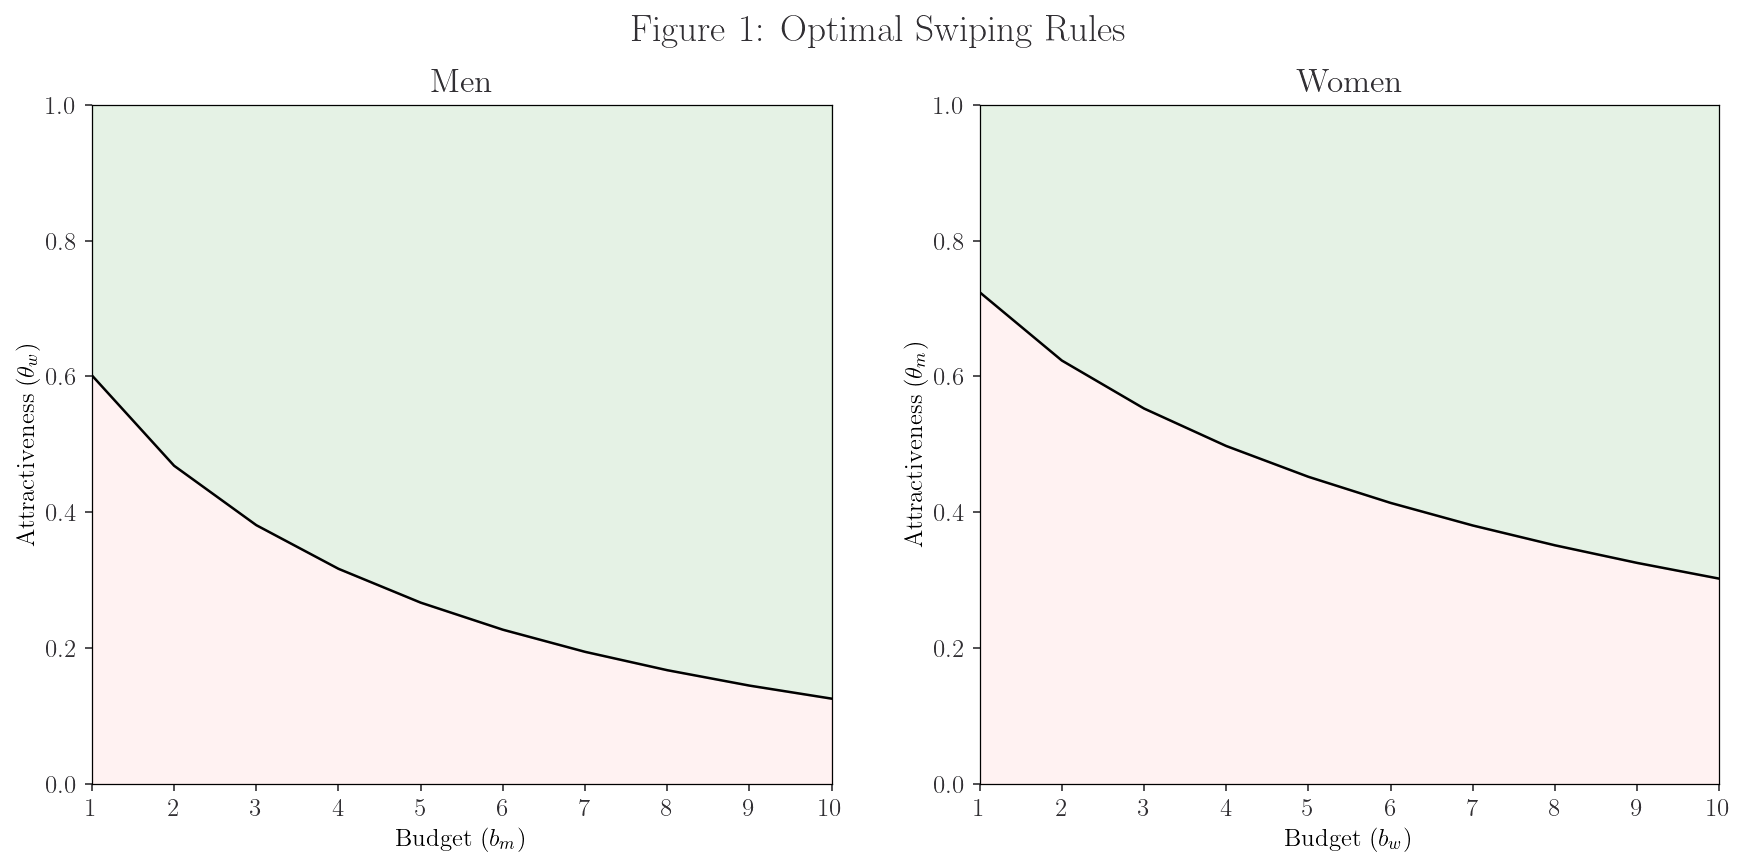

In [10]:
# Plotting swiping rule    
fig, axs = plt.subplots(1,2,figsize=(14, 6))

for i in range(2):
    B = Bm if i==0 else Bw
    b_vals = bm_vals if i==0 else bw_vals
    θ_vals = μ_star if i==0 else ω_star
    
    axs[i].set_xlim(1,B)
    axs[i].set_ylim(0,1)
    axs[i].plot(b_vals, θ_vals, color='k')
    axs[i].fill_between(b_vals, 0, θ_vals, color='red', alpha=0.05)
    axs[i].fill_between(b_vals, θ_vals, 1, color='green', alpha=0.1)
    
axs[0].set_title('Men',loc='center')
axs[0].set(xlabel=r'Budget ($b_m$)', ylabel=r'Attractiveness ($\theta_w$)')
axs[1].set_title('Women',loc='center')
axs[1].set(xlabel=r'Budget ($b_w$)', ylabel=r'Attractiveness ($\theta_m$)')
fig.suptitle('Figure 1: Optimal Swiping Rules')
plt.show()